In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.40', '1.0.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-kannada/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-kannada/classification')

In [7]:
!ls

Kannada_Classification_Data_News_Headlines.csv
Kannada_Classification_Model.ipynb


In [9]:
df = pd.read_csv(path/'Kannada_Classification_Data_News_Headlines.csv')
df.tail()

,headline,label
6455,804 ಕೋಟಿ ಪರಿಹಾರ ಕೋರಿ ಆ್ಯಪಲ್ ಮೇಲೆ ಮೊಕದ್ದಮೆ,tech
6456,ಮಧ್ಯದ ಬೆರಳು ತೋರುವ ಎಮೋಜಿ ತೆಗೆಯುವಂತೆ ವಾಟ್ಸಾಪ್`ಗೆ...,tech
6457,ಜಗತ್ತಿಗೆ ಬರುತ್ತಿದ್ದಾನೆ ಮತ್ತೊಬ್ಬ ಹೊಸ ದೇವರು.. ನಿ...,tech
6458,ನೀವೂ ಮೊಬೈಲನ್ನ ಸಮೀಪದಲ್ಲೇ ಇಟ್ಕೊಂಡು ಮಲಗ್ತೀರಾ..? ಹ...,tech
6459,ರಿಲಾಯನ್ಸ್ ಜಿಯೋದಿಂದ ಗ್ರಾಹಕರಿಗೆ ಭರ್ಜರಿ ಹೊಸ ವರ್ಷದ...,tech


In [10]:
df['label'].unique()

array(['entertainment', 'sports', 'tech'], dtype=object)

In [11]:
print('Entertainment', (df['label'] == 'entertainment').sum())
print('Sports', (df['label'] == 'sports').sum())
print('Tech', (df['label'] == 'tech').sum())

Entertainment 3371
Sports 2326
Tech 763


In [12]:
df['headline'][0]

'ಡಬ್ಬಿಂಗ್\u200b ಪರ-ವಿರೋಧದ ನಡುವೆ ನಲುಗುತ್ತಿದ್ದಾರಾ ಕನ್ನಡದ ಕಲಾವಿದರು..?'

In [13]:
df.shape

(6460, 2)

In [14]:
df[df['headline'].isnull()].shape

(0, 2)

In [15]:
label_cols = list(range(1,df.shape[1]))

In [16]:
print(label_cols)

[1]


In [17]:
id_to_col = list(df.columns)

In [18]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [19]:
class KannadaTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/kannada_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [20]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/kannada_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(25000)]

In [21]:
itos

['<unk>',
 '<s>',
 '</s>',
 '.',
 ',',
 '▁',
 '▁ಮತ್ತು',
 'ದ',
 '▁ಈ',
 'ಗಳು',
 'ಯ',
 'ಗಳ',
 'ಗಳನ್ನು',
 'ರ',
 '▁ಒಂದು',
 'ವನ್ನು',
 '-',
 'ವು',
 'ನ',
 'ರು',
 '▁ನ',
 '▁ಹಾಗೂ',
 'ು',
 'ದಲ್ಲಿ',
 'ಕ್ಕೆ',
 'ಯನ್ನು',
 'ಗೆ',
 'ಸ್',
 '▁ಎಂದು',
 '▁ಅಥವಾ',
 'ಗಳಲ್ಲಿ',
 '▁ಇದು',
 'ರಲ್ಲಿ',
 '▁"',
 'ಿ',
 '"',
 '▁ಅವರು',
 "'",
 '▁ಎಂಬ',
 '▁ಆ',
 'ವಾಗಿ',
 'ಯು',
 '್',
 '▁ಅವರ',
 "▁'",
 '▁ಮೇಲೆ',
 'X',
 '▁�',
 'ವಾದ',
 '▁q',
 'ದಿಂದ',
 'ಗಳಿಗೆ',
 'ಯಲ್ಲಿ',
 'ಲು',
 '▁ತಮ್ಮ',
 '▁ತನ್ನ',
 ':',
 '▁ನಲ್ಲಿ',
 'ನ್ನು',
 'ನ್',
 'ಾ',
 '▁ನಂತರ',
 'ಲ್ಲಿ',
 '▁ಆದರೆ',
 'ಕ',
 '▁ಹೆಚ್ಚು',
 '▁ಮೂಲಕ',
 '▁ಅ',
 'ರ್',
 'ಲ್',
 ';',
 'ಗಳಿಂದ',
 'ುವ',
 '▁ಕೆಲವು',
 'ನು',
 'ಟ್',
 'ವ',
 '▁ಪ್ರಮುಖ',
 '▁ಅನೇಕ',
 '▁ರ',
 '▁ರಲ್ಲಿ',
 'ವಾಗಿದೆ',
 'ಯಿಂದ',
 'ಸಿ',
 '▁ಸುಮಾರು',
 'ಕ್',
 '▁ಎರಡು',
 '▁-',
 '▁ಇದರ',
 'ೆ',
 '▁ಮೊದಲ',
 '▁ಅದರ',
 'ಡ್',
 'ಸ',
 '�',
 'ುತ್ತದೆ',
 '▁ಇದನ್ನು',
 '▁ಹಾಗು',
 'ಾಗ',
 'ದೆ',
 'ಿತು',
 'ಲ',
 '▁ಇತರ',
 'ಿಂದ',
 'ಲಿ',
 'ರಿ',
 '/',
 'ಂ',
 'ಮ್',
 'ರೆ',
 '▁ಕನ್ನಡ',
 '▁ಅದು',
 '▁ಬಗ್ಗೆ',
 'ಯೂ',
 '▁ಅತ್ಯಂತ',
 '▁ಸಹ',
 'ಿಗೆ',
 'ವಿ',
 '▁·',
 '▁ಸಾಮಾನ್ಯವಾಗಿ',
 '▁ಹೆಚ

In [22]:
# 25,000 is the vocab size that we chose in sentencepiece
kannada_vocab = Vocab(itos)

In [23]:
tokenizer = Tokenizer(tok_func=KannadaTokenizer, lang='kn')

In [24]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [25]:
data_lm = TextDataBunch.from_csv(path=path, csv_name='Kannada_Classification_Data_News_Headlines.csv', text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=kannada_vocab)

In [26]:
data_lm.save()

In [27]:
bs=48

In [28]:
data_lm = TextLMDataBunch.load(path, 'tmp', bs=bs)

In [29]:
data_lm.show_batch()

idx,text
0,▁x x b os ▁ಆಂಗ್ಲ ರ ▁ಅಂಗಳ ದಲ್ಲಿ ▁ಇಂದಿನ ಿಂದ ▁ಬಿಗ್ ▁ಫೈ ಟ್ : ▁ಮೊದಲ ▁ಟಿ -20 ▁ಕದನ ಕ್ಕೆ ▁ಭಾರತ - ಇಂಗ್ಲೆಂಡ್ ▁ಸ ಜ್ಜ ು ▁x x b os ▁' ಮಲಾ ಲ ' ▁ಜೀವನ ಾಧಾರಿತ ▁' ಗು ಲ್ ▁ಮ ಕೈ ' ▁ಚಿತ್ರದ ▁ಫಸ್ಟ್ ▁ಲುಕ್ ▁ಬಿಡುಗಡೆ ▁x x b os ▁ಐಪಿಎಲ್ ▁ನ ▁ಪಂಜಾಬ್ ▁ತಂಡದಲ್ಲಿ ▁ಮಿಂಚ ಲು ▁ಸಿದ್ಧ ರಾದ ▁ಕನ್ನಡ ಿಗ ▁ಕೆ . ಎಲ್ . ▁ರಾಹುಲ್ ▁x x b os ▁20 20
1,ರಾಮ್ ▁ಲೀಲಾ ' ▁ಜೋಡಿ ▁ನಿಶ್ಚಿತಾರ್ಥ ? ▁x x b os ▁ಮೊದಲ ▁ಮಗುವಿನ ▁ಸಂಭ್ರಮ ದಲ್ಲಿ ▁ಯ ಶ್ ▁- ರಾಧ ಿಕಾ ▁ವಿದೇಶದಲ್ಲಿ ▁ಫೋಟೋ ಶೂ ಟ್ ▁ . . ! ▁x x b os ▁' ಅಭಿ ಮಾನ ೋತ್ಸವ ' : ▁ಶಿವ ಣ್ಣ ನ ▁ಹುಟ್ಟು ಹಬ್ಬ ಕ್ಕೆ ▁ಬಿರುಸಿನ ▁ಸಿದ್ಧತೆ ▁x x b os ▁ಹಿರಿಯ ▁ನಟ ▁ಚಂದ್ರಶೇಖರ್ ▁ನಿಧನ ಕ್ಕೆ ▁ಚಿತ್ರರಂಗದ ▁ಗಣ್ಯ ರ ▁ಕಂಬ ನಿ ▁x x b os ▁' ಭಾರತ ್ ' ▁ಸಿನಿಮಾ ಗಾಗಿ ▁ನಟಿ
2,▁ಬರೆದ ▁ ಹನುಮ ▁ವಿಹಾರ ಿ ▁x x b os ▁ಹಾಟ್ ▁ಲುಕ್ ▁ನಿಂದ ▁ಅಭಿಮಾನಿ ಗಳ ▁ಕೆ ಂಗ ಣ್ಣ ಿಗೆ ▁ಗುರಿಯಾದ ▁ಮೇ ಘ ನಾ . . ! ▁x x b os ▁ಕೊನೆಯ ▁ಹಂತ ▁ತಲುಪ ಿರುವ ▁' ಬಿ ಗ್ ▁ಬಾಸ್ ▁' ▁ಮನೆಯಲ್ಲಿ ▁ಈ ▁ವಾರ ▁ಏನ ೆಲ್ಲಾ ▁ಆ ಯ್ ತು ▁ಗೊತ್ತ ಾ ? ▁x x b os ▁ಲೈಂಗಿಕ ▁ಕಿರುಕುಳ ▁ನೀಡಿದ್ದ ▁ದಕ್ಷಿಣದ ▁ನಟ ನಿಗೆ ▁ಕ ಪಾ ಳ ▁ಮೋಕ್ಷ ▁ಮಾಡಿದ್ದ ರಂತೆ ▁ನಟಿ ▁ರಾಧ ಿಕಾ ▁ಆಪ್ ಟೆ
3,▁c up ▁20 19 : ▁ವಿಶ್ವಕಪ್ ▁ನಲ್ಲಿ ▁ಭಾರತ - ಪಾ ಕ್ ▁ಪಂದ್ಯ ▁ವೇಳಾಪಟ್ಟಿ ಯಂತೆ ▁ನಡೆಯ ಲಿದೆ ; ▁ಐಸಿಸಿ ▁ಸ್ಪಷ್ಟ ನೆ ▁x x b os ▁p ho to s : ▁ದೀಪ ಿಕಾ - ರಣ ವೀರ್ ▁ಸಿಂಗ್ ▁ವಿವಾಹ ಕ್ಕೆ ▁ಕಂ ಟಕ : ▁ಮದುವೆ ಗೆ ▁ಮುನ್ನ ▁ನಡೆಯ ಲಿದೆ ▁ವಿಶೇಷ ▁ಪೂಜೆ . . ! ▁x x b os ▁ಐಪಿಎಲ್ ▁2018 : ▁ರಾಜಸ್ಥಾನ ್ ▁ರಾಯಲ್ ಸ್ ▁ಮತ್ತು ▁ಮುಂಬೈ ▁ಇಂಡಿಯನ್ ಸ್ ▁ಪಂದ್ಯಗಳ ▁ನಡುವಣ ▁ಫೋಟೋ
4,ಯಲ್ಲಿ ▁ಲೋಕ ಲ್ ▁ಹುಡುಗ ರೊಂದಿಗೆ ▁ಕ್ರಿಕೆಟ್ ▁ಆಡಿದ ▁ತೆಂಡೂಲ್ಕರ್ ! : ▁ವೈ ರಲ್ ▁ಆ ಯ್ ತು ▁ವಿಡಿಯೋ ▁x x b os ▁ಭಾರತ ▁v s ▁ಆಸ್ಟ್ರೇಲಿಯಾ : ▁ವಿಕೆಟ್ ▁ಹಿಂದೆ ▁ನಿಂತು ▁ವಿಶ್ವ ▁ದಾಖಲೆ ▁ಸರಿ ಗಟ್ಟಿ ದ ▁ಪಂತ ್ ▁x x b os ▁ವರ್ಷದ ▁ಕನ್ನಡ ಿಗ ▁2018 ರ ▁ಸಿನೆಮಾ ▁ವಿಭಾಗದಲ್ಲಿ ▁ನಾಮ ▁ನಿರ್ದೇಶನ ಗೊಂಡ ವರ ▁ವಿವರಗಳು ▁x x b os ▁ರಕ್ತ ▁ಸಿ ಕ್ತ ▁ಥ್ರ ಿಲ್ಲ ರ್ ▁ಕಥೆ ಯೊಂದಿಗೆ ▁ಮರಳ ಿದ್ದಾರೆ ▁ಸು ನೀ ಲ್ ▁ಕುಮಾರ್ ▁ದೇಸಾಯಿ


In [30]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [45]:
# Loading the pretrained language model on kannada wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-kannada/language-model/KannadaDataset/models/third_kn_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (5167 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-kannada/classification
x: LMTextList (5167 items)
[Text ▁x x b os ▁ತೆರೆ ಗೆ ▁ಬರ ಲ್ಲ ▁' ಕಾಲ ಾ ' ▁ಸಿನಿಮಾ : ▁ರ ಜ ನಿ - ಕ ಮಲ್ ▁ಚಿತ್ರಗಳಿಗೆ ▁ರಾಜ್ಯದಲ್ಲಿ ▁ಬಿಡುಗಡೆ ▁ಭಾಗ್ಯ ವಿಲ್ಲ, Text ▁x x b os ▁ಗೆಲುವಿನ ▁ತ ವ ಕ ದಲ್ಲಿ ▁ಟೀಮ್ ▁ಇಂಡಿಯಾ : ▁ಕೊಲ ಂಬೋ ದಲ್ಲಿ ▁ಭಾರತ - ಶ್ರೀ ಲಂಕ ಾ ▁ಮುಖಾಮುಖಿ, Text ▁x x b os ▁ಇಟಲಿಯಲ್ಲಿ ▁ನಡೆಯ ಲಿರುವ ▁ದೀಪ ಿಕಾ - ರಣ ವೀರ್ ▁ವಿವಾಹ ಕ್ಕೆ ▁ಮೊಬೈಲ್ ▁ನಿಷೇಧ . . !, Text ▁x x b os ▁' ಪ್ ರೀ ಮಿ ಯರ್ ▁ಪದ್ಮ ಿನಿ ' ▁ಏರ ಲಿರುವ ▁ನವರ ಸ ▁ನಾಯಕ ▁ಜಗ್ಗ ೇಶ್, Text ▁x x b os ▁ಜಗತ್ತಿಗೆ ▁ಬ್ಯಾಟಿಂಗ್ , ▁ಬೌಲಿಂಗ್ ▁ಹೇಳಿಕೊಟ್ಟ ▁ಆಂಗ್ಲ ರಿಗೆ ▁1000 ನೇ ▁ಟೆಸ್ಟ್]...
Path: /home/gaurav/PycharmProjects/nlp-for-kannada/classification;

Valid: LabelList
y: LMLabel (1293 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: /home/gaurav/PycharmProjects/nlp-for-kannada/classification
x: LMTextList (1293 items)
[Text ▁x x b os ▁ಸ್ಟ ಂಟ

In [46]:
# Fine tuning the prtrained LM on current dataset

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


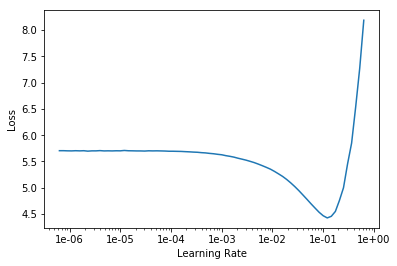

In [34]:
learn.recorder.plot()

In [47]:
learn.freeze()

In [48]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,5.075233,4.528327,0.334799


In [49]:
learn.save('fit_head', with_opt=True)

In [50]:
learn.load('fit_head', with_opt=True);

In [51]:
learn.unfreeze()

In [52]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.327314,4.314559,0.354255
2,4.134565,4.014318,0.395315
3,3.898810,3.815121,0.420128
4,3.655549,3.699789,0.434932
5,3.415615,3.647500,0.441744
6,3.195820,3.620418,0.448600
7,3.002643,3.621196,0.448975
8,2.841563,3.625900,0.450529
9,2.727018,3.630910,0.450705
10,2.653306,3.632526,0.450705


In [53]:
learn.save('fine_tuned', with_opt=True)

In [54]:
learn.load('fine_tuned', with_opt=True);

In [55]:
learn.predict('ರಾಮ್',n_words=10)

'ರಾಮ್ - ಐ ಟಿ ▁ನೆರವಾಗ ▁ಪ್ರ ಸ್ತಾ ರ ▁ಬೈ ಲ್ ▁'

In [56]:
learn.save_encoder('fine_tuned_enc')

In [57]:
data_clas = TextClasDataBunch.from_csv(path=path, csv_name='Kannada_Classification_Data_News_Headlines.csv', tokenizer=tokenizer, vocab=kannada_vocab, text_cols=[0], label_cols=label_cols)

In [58]:
data_clas.show_batch()

text,target
▁x x b os ▁ y a am ana vi e ▁bo x ff ice ▁c oll ection s : ▁ಬಾ ಕ್ಸಾ ಫಿ ಸ್ ▁ನಲ್ಲಿ ▁ಧೂಳ ೆ ಬ್ಬ ಿಸುತ್ತಿರುವ ▁ಡಿ - ಬಾ ಸ್ ▁: ▁ಮೂರು ▁ದಿನಗಳಲ್ಲಿ ▁' ಯ ಜ ಮಾನ ' ನ ▁ಗಳಿಕೆ ▁ಎಷ್ಟು ▁ಗೊತ್ತ ಾ . . ?,entertainment
▁x x b os ▁ l iv e ) : ▁ಐಪಿಎಲ್ ▁2018 : ▁ಆರ್ ▁ಸಿ ಬಿ ▁v s ▁ಡೆ ಲ್ಲಿ ▁ಡೇ ರ್ ▁ ಡೆವಿಲ್ಸ್ ▁: ▁ಡೆ ಲ್ಲಿ ▁ಬೌಲರ್ ಸ್ ▁ಗಳ ▁ಬೆ ಂಡೆ ತ್ತಿ ದ ▁ವಿ ಲಿಯರ್ ಸ್ ▁: ▁ಆರ್ ▁ಸಿ ಬಿ ಗೆ ▁6 ▁ವಿಕೆಟ್ ಸ್ ▁ಗಳ ▁ಭರ್ಜರಿ ▁ಜಯ,sports
"▁x x b os ▁l iv e ▁s c ore , ▁v s ▁a ust ral ia , ▁1 st ▁t 20 i : ▁ಧ ವನ್ ▁ಹೋರಾಟ ▁ವ್ಯರ್ಥ : ▁ರೋಚಕ ▁ಪಂದ್ಯದಲ್ಲಿ ▁ಗೆದ್ದು ▁ಬೀಗ ಿದ ▁ಕಾಂ ಗರು ಗಳು",sports
▁x x b os l ▁v s ▁l ok ▁s ab ha ▁ elect ions : ▁ಐಪಿಎಲ್ - ಲೋಕ ಸಭೆ ▁ಅಂತಿಮ ▁ಹಣ ಾಹ ಣಿ ▁ಕ್ಲ ್ಯಾ ಶ್ ▁! ; ▁ಬಿಸಿ ಸಿ ಐ ▁ನಿರ್ಧಾರ ವೇ ನು ▁ಗೊತ್ತ ಾ ?,sports
▁x x b os ▁ y a am ana vi e ▁re view : ▁ಕಾವೇರಿ ▁ಕಾಯ ುವ ▁ದಾಸ ▁ಎಲ್ಲರಿಗೂ ▁ಖಾ ಸ ▁ಖಾ ಸ : ▁ಸಿನಿಮಾ ▁ನೋಡಿದ ವ ▁ಹೇಳ ೋ ದು ▁ನಾ ನೇ ▁' ಯ ಜ ಮಾನ ' . . !,entertainment


In [59]:
data_clas.sanity_check()

In [60]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)

In [61]:
learn.load_encoder('fine_tuned_enc')

In [62]:
learn.freeze()

In [63]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


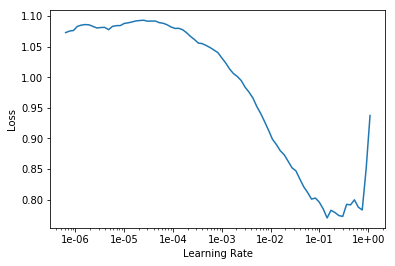

In [64]:
learn.recorder.plot()

In [65]:
learn.loss_func.func

CrossEntropyLoss()

In [66]:
kappa = KappaScore()

In [67]:
learn.metrics = [kappa, accuracy]

In [68]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.382422,0.231807,0.856039,0.915700


In [69]:
learn.save('first-full')

In [70]:
learn.load('first-full');

In [71]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,kappa_score,accuracy
1,0.319180,0.202231,0.876547,0.928074
2,0.262814,0.172914,0.894391,0.938128
3,0.192122,0.196444,0.887595,0.934261
4,0.155507,0.196938,0.905109,0.944316
5,0.116636,0.204341,0.906504,0.945089


In [72]:
learn.save('final')

In [75]:
learn.predict('ಬಾಲಿವುಡ್ ಸ್ಟಾರ್ ನಟನ ಸಿನಿಮಾದಲ್ಲಿ ಸೌತ್ ಸುಂದರಿ ಕೀರ್ತಿ ಸುರೇಶ್')

(Category entertainment,
 tensor(0),
 tensor([9.9999e-01, 1.2858e-05, 1.8295e-07]))

In [76]:
learn.predict("ಚಿತ್ರರಂಗದಿಂದ ಯಾರ್ ಯಾರು ಬರ್ತಾರಂತಾ ಮಾರ್ಚ್ 18ಕ್ಕೆ ನೋಡಿ")

(Category entertainment, tensor(0), tensor([0.9083, 0.0817, 0.0099]))

In [77]:
learn.predict("ಮತದಾನದ ಅರಿವು ಮೂಡಿಸುವಂತೆ ಸಿನಿತಾರೆಯರಿಗೆ ಪ್ರಧಾನಿ ಮೋದಿ ಕರೆ")

(Category entertainment,
 tensor(0),
 tensor([9.9751e-01, 1.7996e-03, 6.8613e-04]))

In [78]:
learn.predict("ಸಿದ್ಧರಾಗಿರಿ ಬರ್ತಾ ಇದೆ 'ಬೆಲ್ ಬಾಟಂ ಪಾರ್ಟ್ -2'")

(Category entertainment,
 tensor(0),
 tensor([9.9222e-01, 1.5559e-04, 7.6263e-03]))